Credits to Elissaios Sarmas for the model training and transfer learning code, which was adapted for use on this dataset. Code can be found here: https://github.com/ElissaiosSarmas/Transfer-learning-strategies-for-solar-power-forecasting-under-data-scarcity

In [16]:
# Clear any logs from previous runs
!rm -r ./LSTM/logs

'rm' is not recognized as an internal or external command,
operable program or batch file.


I will use a dataset obtained from Kaggle (credits to Afroz) that has 8760 entries and contains hourly PV output to train the base model.

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import math
import tensorflow as tf
import datetime, os
from tensorflow.keras.models import Model
from tensorflow.keras.metrics import MeanAbsoluteError, RootMeanSquaredError
from keras_layer_normalization import LayerNormalization
from keras.preprocessing import sequence
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, LSTM, Dense, Dropout, BatchNormalization
from tensorflow import keras
import time
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from hyperopt import fmin, tpe, hp, partial, Trials, STATUS_OK, STATUS_FAIL, space_eval
from tensorflow.keras.regularizers import l1, l2
from tensorflow.keras import layers

from sklearn.model_selection import GridSearchCV, train_test_split, KFold, cross_val_score 
from sklearn import metrics
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.callbacks import EarlyStopping
from math import sqrt
from sklearn.metrics import mean_squared_error, zero_one_loss,mean_absolute_error,r2_score
pd.options.mode.chained_assignment = None
import warnings
warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)

In [18]:
path = "C:/work/Honours code/Datasets/Kaggle-Solar-PV-data/Solar Power Plant Data.csv"

p0 = pd.read_csv(path, header=0)

In [19]:
p0_copy = p0.copy()
p0_copy['timestamp'] = pd.to_datetime(p0['Date-Hour(NMT)'], format='%d.%m.%Y-%H:%M')

p0_copy.drop(['Date-Hour(NMT)'], axis=1, inplace=True)

timestamp = p0_copy.pop('timestamp')
p0_copy.insert(0, 'timestamp', timestamp)
p0_copy['hour'] = pd.to_datetime(p0_copy['timestamp']).dt.hour
p0_copy['month'] = pd.to_datetime(p0_copy['timestamp']).dt.month

In [20]:
p0_copy.head()

,timestamp,WindSpeed,Sunshine,AirPressure,Radiation,AirTemperature,RelativeAirHumidity,SystemProduction,hour,month
0,2017-01-01 00:00:00,0.6,0,1003.8,-7.4,0.1,97,0.0,0,1
1,2017-01-01 01:00:00,1.7,0,1003.5,-7.4,-0.2,98,0.0,1,1
2,2017-01-01 02:00:00,0.6,0,1003.4,-6.7,-1.2,99,0.0,2,1
3,2017-01-01 03:00:00,2.4,0,1003.3,-7.2,-1.3,99,0.0,3,1
4,2017-01-01 04:00:00,4.0,0,1003.1,-6.3,3.6,67,0.0,4,1


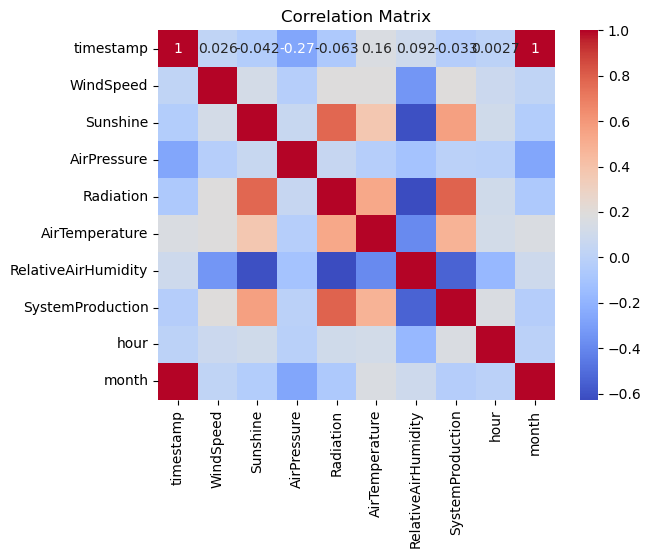

In [21]:
corr_matrix = p0_copy.corr()
# Plot the correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [22]:

# Perform One-Hot-Encoding for Months and Sin-Cos Similarities for Hours
data = p0_copy
data['timestamp'] = pd.to_numeric(data['timestamp'])
data = pd.get_dummies(data, columns=['month'])
data.loc[:,'sin_hour'] = np.sin(2*np.pi*data['timestamp']/24)
data.loc[:,'cos_hour'] = np.cos(2*np.pi*data['timestamp']/24)

print("Total Dataset =", len(data))

Total Dataset = 8760


In [23]:
# Shaping data for LSTM input
def split_sequences(sequences, n_steps, n_outputs, only_production, validation_split):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern 
        end_ix = i + n_steps
        # check if we are beyond the dataset
        if end_ix + n_outputs > len(sequences):
            break
        # gather input and output parts of the pattern
        if only_production==True:
            seq_x, seq_y = sequences[i:end_ix, -1], sequences[end_ix:(end_ix+n_outputs), -1]
        else:
            seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:(end_ix+n_outputs), -1]
            
        X.append(seq_x)
        y.append(seq_y)
    
    # Convert to numpy arrays
    X, y = np.array(X), np.array(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [24]:
def unique_shapes(x, y, lag_, n_features_, num_of_outputs_, only_production, validation_split):
    unique_shapes = []
    for k in range(len(x)):
        if only_production==True:
            if (x[k].shape == (lag,)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)
        else:
            if (x[k].shape == (lag_, n_features_)) & (y[k].shape == (num_of_outputs_,)):
                unique_shapes.append(k)       
    x = x[unique_shapes]
    y = y[unique_shapes]
    x = np.stack(x)
    y = np.stack(y)
    
    # Split the data into training and validation sets
    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=validation_split, random_state=42)
    
    return x_train, x_val, y_train, y_val

In [25]:
# Select the columns that you want to use as features
cols = [
    "timestamp",
    "WindSpeed",
    "Sunshine",
    "AirPressure",
    "Radiation",
    "AirTemperature",
    "RelativeAirHumidity",
    "sin_hour",
    "cos_hour",
    "SystemProduction",
    ]
# Set to True if using only the production, else to False
only_production = False
# Splitting factor for training set and test set
split = 0.8

# Select the lag variable, the number of features (must be same with cols selected) and the horizon
lag = 5
n_features = len(cols)
num_of_outputs = 1

In [26]:
# Scale data seperately
from sklearn.preprocessing import MinMaxScaler

if only_production == True:
    data_ = data_['SystemProduction']
    train = data_.iloc[:int(len(data_)*split_),]
    test = data_.iloc[int(len(data_)*split_):,]
    scaler = MinMaxScaler(feature_range=(0, 1))
    train = scaler.fit_transform(train.values.reshape(-1, 1))
    test = scaler.fit_transform(test.values.reshape(-1, 1))
else:
    data = data[cols]
    train = data.iloc[:int(len(data)*split),:]
    test = data.iloc[int(len(data)*split):,]
    scaler = MinMaxScaler(feature_range=(0,1))
    train = scaler.fit_transform(train)
    test = scaler.fit_transform(test)

In [27]:
# Create the input for LSTM: x(batch_size, lag, features), y(batch_size,)

x_train, x_val, y_train, y_val = split_sequences(train, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = split_sequences(test, n_steps=lag, n_outputs=num_of_outputs, only_production=only_production, validation_split=split)

x_train, x_val, y_train, y_val = unique_shapes(x_train, y_train, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)
x_test, x_val, y_test, y_val = unique_shapes(x_test, y_test, lag, n_features, num_of_outputs, only_production=only_production, validation_split=split)

# Reshape for only_production case
if only_production:
    x_train = x_train.reshape((x_train.shape[0], lag, 1))
    x_test = x_test.reshape((x_test.shape[0], lag, 1))
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2])
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2])
# Print the shapes
print("Size of Train / Test =", x_train.shape, y_train.shape, x_test.shape, y_test.shape)


Size of Train / Test = (280, 5, 10) (280, 1) (69, 5, 10) (69, 1)


In [28]:
def percentage_error(actual, predicted):
    res = np.empty(actual.shape)
    for j in range(actual.shape[0]):
        if actual[j] != 0:
            res[j] = (actual[j] - predicted[j]) / actual[j]
        else:
            res[j] = predicted[j] / np.mean(actual)
    return res

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs(percentage_error(np.asarray(y_true), np.asarray(y_pred))))

def createModel():

    # LSTM Model Architecture

    optimizer = Adam(learning_rate=0.002, clipvalue=0.5)
    model = Sequential()
    model.add(Bidirectional(LSTM(32,
                                 activation="relu",
                                 return_sequences=True),
                                input_shape=(x_train.shape[1], x_train.shape[2]), name = 'bidirectional_1'))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(128,activation="relu",return_sequences=True), name = 'bidirectional_2'))
    model.add(Dropout(0.4))
    model.add(Bidirectional(LSTM(256,activation="relu",return_sequences=False), name = 'bidirectional_3'))
    model.add(Dense(1, name='output_layer'))
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])

    # renaming weight handles to ensure uniqueness
    # credits to Nour Alden
    # from https://stackoverflow.com/questions/72776335/valueerror-unable-to-create-dataset-name-already-exists-when-using-modelcheck

    for i in range(len(model.weights)):
        model.weights[i]._handle_name = model.weights[i].name + "_" + str(i)

    model.summary()
    return model

In [29]:
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from keras.layers import TFSMLayer
import h5py
import os
import time
timestamp = int(time.time())
true_values = []
predicted_values = []
#model_path = "C:/work/Honours code/Transfer learning/LSTM/model/LSTM_base.h5"
model_path = "model/LSTM_base.h5"
def fit_predict_stats(model):
    # Early stopping property
    es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
    tb = TensorBoard(log_dir='logs')
    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
    history = model.fit(x_train, y_train, epochs=100, validation_split=0.14, batch_size=32, verbose=1, shuffle=True, callbacks=[tensorboard_callback, es]).history
   
    
    if os.path.exists(model_path):
        
    # Load the model
        tf.debugging.set_log_device_placement(True)
        model = load_model(model_path)
    else:
        # Model file does not exist, so save the model
        
        # Fit the model
        model.save(model_path, overwrite=True)



    # summarize history for MAE and MSE
    # plt.plot(history['loss'])
    # plt.plot(history['val_loss'])
    # plt.title('model loss')
    # plt.ylabel('Model MSE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # plt.figure()
    # plt.plot(history['mae'])
    # plt.plot(history['val_mae'])
    # plt.title('Model MAE')
    # plt.ylabel('MAE')
    # plt.xlabel('epoch')
    # plt.legend(['train', 'val'], loc='upper left')

    # Metrics on scaled data
    
    from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
    y_pred = model.predict(x_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    mae = mean_absolute_error(y_train, y_pred)
    # print('Train Scaled RMSE: {}'.format(rmse))
    # print('Train Scaled MAE: {}'.format(mae))
    # print('Train Scaled R2 Score: ', r2_score(y_train, y_pred)*100)

    y_pred = model.predict(x_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    # print('Test Scaled RMSE: {}'.format(rmse))
    # print('Test Scaled MAE: {}'.format(mae))
    # print('Test Scaled R2 Score: ',r2_score(y_test, y_pred)*100)


    
    # Metrics on original data
    true = []
    hat = []
    range_ = [0]
    # range_ = list(range(6))

    for i,j in zip([[x_train,y_train],[x_test,y_test]],['Train','Test']):
        # make a prediction
        yhat = model.predict(i[0])
        if yhat.shape == (yhat.shape[0],):
            yhat = yhat.reshape((yhat.shape[0],1))  
      
        y_hat = []
        for k in range(len(yhat)):
            if k == 0:
                for l in range_:
                    y_hat.append(yhat[k,l])
            else:
                y_hat.append(yhat[k,-1])
        
        y_hat = np.stack(y_hat)
        y_hat = y_hat.reshape((y_hat.shape[0],1))
        
        i[0] = i[0].reshape((i[0].shape[0],lag,n_features))
        
        x_hat = []
        for k in range(len(i[0])):
            if k == 0:
                x_hat.append(i[0][k])
            elif k!= 0:
                x_hat.append(i[0][k][-1,:])
        
        x_hat = np.vstack(x_hat)
        
        initial_x_hat_shape = x_hat.shape[0]
        initial_y_hat_shape = y_hat.shape[0]
        
        # print(x_hat.shape)
        # print(y_hat.shape)
        
        if x_hat.shape[0]-y_hat.shape[0] != 0.0:
            if x_hat.shape[0] > y_hat.shape[0]:
                for k in range(x_hat.shape[0]-y_hat.shape[0]):
                    y_hat = np.insert(y_hat, 0, y_hat[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_hat.shape[0]:
                y_hat = y_hat[-int(x_hat.shape[0]-y_hat.shape[0]):,:]
                added_values = False
        
        # print(x_hat.shape)
        # print(y_hat.shape)
        
        # invert scaling for forecast
        if only_production==True:
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
        else:    
            inv_yhat = np.concatenate((x_hat[:,:-1],y_hat), axis=1)
            inv_yhat = scaler.inverse_transform(inv_yhat)
            inv_yhat = inv_yhat[:,-1]
            
        # invert scaling for actual
        y_true = []
        for k in range(len(i[1])):
            if k ==0:
                for l in range_:
                    y_true.append(i[1][k,l])
            else:
                y_true.append(i[1][k,-1])

        y_true = np.stack(y_true)
        y_true = y_true.reshape((y_true.shape[0],1))
        print(y_true.shape)

        initial_y_true_shape = y_true.shape[0]
        
        if x_hat.shape[0]-y_true.shape[0] != 0.0:
            if x_hat.shape[0] > y_true.shape[0]:
                for k in range(x_hat.shape[0]-y_true.shape[0]):
                    y_true = np.insert(y_true, 0, y_true[0,0], axis=0)
                    added_values = True
            elif x_hat.shape[0] < y_true.shape[0]:
                y_true = y_true[-int(x_hat.shape[0]-y_true.shape[0]):,:]
                added_values = False
                
        if only_production==True:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
        else:
            inv_y = np.concatenate((x_hat[:,:-1],y_true), axis=1)
            inv_y = scaler.inverse_transform(inv_y)
            inv_y = inv_y[:,-1]
        
        true.append(inv_y)
        hat.append(inv_yhat)

        # true_values.append(true)
        # predicted_values.append(hat)
        
        # calculate RMSE
        rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
        print('Test RMSE: %.3f' % rmse)
        # calculate MAE
        mae = mean_absolute_error(inv_y, inv_yhat)
        print('Test MAE: %.3f' % mae)
        # calculate R2
        r2 = r2_score(inv_y, inv_yhat)
        print('Test R2 Score: ',r2)
        # Calculate MAPE
        mape = mean_absolute_percentage_error(inv_y, inv_yhat)
        print('MAPE', mape)
        # Calculate MBE
        mbe = np.mean(inv_yhat - inv_y)
        print('Test MBE', mbe)
        # Calculate nRMSE
        nRMSE = rmse / np.mean(inv_y)
        print('nRMSE', nRMSE)

        



    mae_list.append(mae)
    rmse_list.append(rmse)
    r_square_list.append(r2)
    mape_list.append(mape)
    mbe_list.append(mbe)
    nRMSE_list.append(nRMSE)



In [30]:
mae_list = []
rmse_list = []
r_square_list = []
mape_list = []
mbe_list = []
nRMSE_list = []
num_iterations = 20
#num_iterations = 2
for i in range(num_iterations):
    # print("Shape of x_train:", x_train.shape)
    # print("Shape of y_train:", y_train.shape)
    # print("Shape of x_test:", x_test.shape)
    # print("Shape of y_test:", y_test.shape)
    model = createModel()
    keras.config.disable_traceback_filtering()
    fit_predict_stats(model)

# sns.set_style("darkgrid")
# for true, hat in zip(true_values, predicted_values):
#     plt.figure()
#     plt.plot(true[1], color="green")
#     plt.plot(hat[1], color="red")
#     plt.savefig('plots/lstm_base_plot.png')
    #plt.show()

print("MAE:", mae_list)
print("RMSE:", rmse_list)
print("R^2:", r_square_list)
print("MAPE:", mape_list)
print("MBE:", mbe_list)
print("nRMSE:", nRMSE_list)

print("Mean MAE:", np.mean(mae_list))
print("Mean RMSE:", np.mean(rmse_list))
print("Mean R^2:", np.mean(r_square_list))
print("Mean MAPE:", np.mean(mape_list))
print("Mean MBE:", np.mean(mbe_list))
print("Mean nRMSE:", np.mean(nRMSE_list))


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 410ms/step - loss: 0.0652 - mae: 0.1856 - val_loss: 0.0384 - val_mae: 0.1013
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 123ms/step - loss: 0.0321 - mae: 0.1065 - val_loss: 0.0237 - val_mae: 0.1053
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0293 - mae: 0.1182 - val_loss: 0.0283 - val_mae: 0.0891
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0293 - mae: 0.0968 - val_loss: 0.0217 - val_mae: 0.0981
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0322 - mae: 0.1171 - val_loss: 0.0216 - val_mae: 0.0835
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0266 - mae: 0.0975 - val_loss: 0.0179 - val_mae: 0.0799
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0260 - mae: 0.1001 - val_loss: 0.0177 - val_mae: 0.0779
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0191 - mae: 0.0800 - val_loss: 0.0175 - val_mae: 0.0756
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0214 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 172ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 20s 415ms/step - loss: 0.0498 - mae: 0.1548 - val_loss: 0.0336 - val_mae: 0.1024
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - loss: 0.0330 - mae: 0.1236 - val_loss: 0.0213 - val_mae: 0.0901
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0299 - mae: 0.1027 - val_loss: 0.0203 - val_mae: 0.0861
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - loss: 0.0220 - mae: 0.0948 - val_loss: 0.0214 - val_mae: 0.0838
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 116ms/step - loss: 0.0232 - mae: 0.0863 - val_loss: 0.0189 - val_mae: 0.0849
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 173ms/step - loss: 0.0234 - mae: 0.1041 - val_loss: 0.0233 - val_mae: 0.0823
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 202ms/step - loss: 0.0245 - mae: 0.0882 - val_loss: 0.0179 - val_mae: 0.0810
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step - loss: 0.0254 - mae: 0.0933 - val_loss: 0.0183 - val_mae: 0.0754
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 201ms/step - loss: 0.01

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 169ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 307ms/step - loss: 0.0558 - mae: 0.1581 - val_loss: 0.0352 - val_mae: 0.1154
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0417 - mae: 0.1535 - val_loss: 0.0266 - val_mae: 0.0898
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0248 - mae: 0.0944 - val_loss: 0.0237 - val_mae: 0.0878
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0316 - mae: 0.1090 - val_loss: 0.0253 - val_mae: 0.0862
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0230 - mae: 0.0924 - val_loss: 0.0207 - val_mae: 0.0976
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0233 - mae: 0.1025 - val_loss: 0.0198 - val_mae: 0.0824
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0219 - mae: 0.0882 - val_loss: 0.0182 - val_mae: 0.0830
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0194 - mae: 0.0849 - val_loss: 0.0189 - val_mae: 0.0806
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0214 - ma

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 352ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 254ms/step - loss: 0.0463 - mae: 0.1479 - val_loss: 0.0312 - val_mae: 0.1029
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 207ms/step - loss: 0.0258 - mae: 0.1106 - val_loss: 0.0232 - val_mae: 0.0871
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step - loss: 0.0291 - mae: 0.0987 - val_loss: 0.0204 - val_mae: 0.0855
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0229 - mae: 0.1017 - val_loss: 0.0193 - val_mae: 0.0853
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0267 - mae: 0.1070 - val_loss: 0.0195 - val_mae: 0.0794
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0262 - mae: 0.1048 - val_loss: 0.0194 - val_mae: 0.0758
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0245 - mae: 0.0853 - val_loss: 0.0187 - val_mae: 0.0795
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 84ms/step - loss: 0.0208 - mae: 0.0842 - val_loss: 0.0168 - val_mae: 0.0722
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 157ms/step - loss: 0.0182 -

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 189ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 418ms/step - loss: 0.0568 - mae: 0.1663 - val_loss: 0.0431 - val_mae: 0.1078
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 100ms/step - loss: 0.0576 - mae: 0.1517 - val_loss: 0.0259 - val_mae: 0.1245
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0279 - mae: 0.1295 - val_loss: 0.0220 - val_mae: 0.0892
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 108ms/step - loss: 0.0341 - mae: 0.1136 - val_loss: 0.0230 - val_mae: 0.0856
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0247 - mae: 0.0952 - val_loss: 0.0191 - val_mae: 0.0882
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 138ms/step - loss: 0.0229 - mae: 0.0999 - val_loss: 0.0199 - val_mae: 0.0814
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - loss: 0.0214 - mae: 0.0885 - val_loss: 0.0177 - val_mae: 0.0793
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0216 - mae: 0.0955 - val_loss: 0.0182 - val_mae: 0.0756
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.019

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 290ms/step - loss: 0.0440 - mae: 0.1429 - val_loss: 0.0276 - val_mae: 0.1306
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0301 - mae: 0.1301 - val_loss: 0.0241 - val_mae: 0.0865
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0263 - mae: 0.0860 - val_loss: 0.0220 - val_mae: 0.0946
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0333 - mae: 0.1073 - val_loss: 0.0202 - val_mae: 0.0876
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0248 - mae: 0.1080 - val_loss: 0.0188 - val_mae: 0.0800
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0236 - mae: 0.0871 - val_loss: 0.0187 - val_mae: 0.0788
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0227 - mae: 0.1010 - val_loss: 0.0165 - val_mae: 0.0791
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0222 - mae: 0.0890 - val_loss: 0.0179 - val_mae: 0.0764
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0183 - ma

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 140ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 24s 263ms/step - loss: 0.0561 - mae: 0.1629 - val_loss: 0.0388 - val_mae: 0.1041
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0349 - mae: 0.1222 - val_loss: 0.0227 - val_mae: 0.1046
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0260 - mae: 0.1033 - val_loss: 0.0226 - val_mae: 0.0889
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0246 - mae: 0.0895 - val_loss: 0.0194 - val_mae: 0.0864
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0253 - mae: 0.1033 - val_loss: 0.0197 - val_mae: 0.0854
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0213 - mae: 0.0914 - val_loss: 0.0187 - val_mae: 0.0933
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0223 - mae: 0.1037 - val_loss: 0.0235 - val_mae: 0.0841
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0245 - mae: 0.0872 - val_loss: 0.0185 - val_mae: 0.0894
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0243 - ma

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 141ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 262ms/step - loss: 0.0546 - mae: 0.1579 - val_loss: 0.0298 - val_mae: 0.1052
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0237 - mae: 0.1077 - val_loss: 0.0206 - val_mae: 0.0877
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0220 - mae: 0.0905 - val_loss: 0.0200 - val_mae: 0.0827
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0274 - mae: 0.1066 - val_loss: 0.0211 - val_mae: 0.0801
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0252 - mae: 0.0957 - val_loss: 0.0187 - val_mae: 0.0795
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 83ms/step - loss: 0.0191 - mae: 0.0880 - val_loss: 0.0173 - val_mae: 0.0725
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0195 - mae: 0.0845 - val_loss: 0.0191 - val_mae: 0.0717
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0186 - mae: 0.0824 - val_loss: 0.0161 - val_mae: 0.0661
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - loss: 0.0185 - ma

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 211ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 22s 344ms/step - loss: 0.0528 - mae: 0.1582 - val_loss: 0.0368 - val_mae: 0.1072
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0363 - mae: 0.1294 - val_loss: 0.0228 - val_mae: 0.1000
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0265 - mae: 0.1022 - val_loss: 0.0196 - val_mae: 0.0860
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0227 - mae: 0.0958 - val_loss: 0.0184 - val_mae: 0.0824
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.0221 - mae: 0.0909 - val_loss: 0.0179 - val_mae: 0.0794
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0260 - mae: 0.1093 - val_loss: 0.0156 - val_mae: 0.0732
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 105ms/step - loss: 0.0201 - mae: 0.0825 - val_loss: 0.0145 - val_mae: 0.0790
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 107ms/step - loss: 0.0226 - mae: 0.0993 - val_loss: 0.0219 - val_mae: 0.0835
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 104ms/step - loss: 0.02

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 362ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 520ms/step - loss: 0.0490 - mae: 0.1514 - val_loss: 0.0300 - val_mae: 0.1067
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0365 - mae: 0.1398 - val_loss: 0.0235 - val_mae: 0.0854
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0323 - mae: 0.1112 - val_loss: 0.0195 - val_mae: 0.0807
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0274 - mae: 0.1035 - val_loss: 0.0237 - val_mae: 0.0817
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0265 - mae: 0.0845 - val_loss: 0.0225 - val_mae: 0.0843
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0229 - mae: 0.1035 - val_loss: 0.0182 - val_mae: 0.0831
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - loss: 0.0236 - mae: 0.0961 - val_loss: 0.0183 - val_mae: 0.0763
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0245 - mae: 0.0948 - val_loss: 0.0164 - val_mae: 0.0767
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0173 - m

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 18s 283ms/step - loss: 0.0536 - mae: 0.1510 - val_loss: 0.0281 - val_mae: 0.1102
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0308 - mae: 0.1269 - val_loss: 0.0240 - val_mae: 0.0894
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0216 - mae: 0.0872 - val_loss: 0.0213 - val_mae: 0.0845
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 126ms/step - loss: 0.0223 - mae: 0.0892 - val_loss: 0.0206 - val_mae: 0.0917
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0254 - mae: 0.1128 - val_loss: 0.0198 - val_mae: 0.0859
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 132ms/step - loss: 0.0192 - mae: 0.0887 - val_loss: 0.0193 - val_mae: 0.0795
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 148ms/step - loss: 0.0203 - mae: 0.0864 - val_loss: 0.0171 - val_mae: 0.0750
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 119ms/step - loss: 0.0220 - mae: 0.0906 - val_loss: 0.0159 - val_mae: 0.0763
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.019

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 515ms/step - loss: 0.0389 - mae: 0.1308 - val_loss: 0.0261 - val_mae: 0.1135
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0253 - mae: 0.1114 - val_loss: 0.0226 - val_mae: 0.0908
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0285 - mae: 0.1006 - val_loss: 0.0245 - val_mae: 0.0904
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0331 - mae: 0.1190 - val_loss: 0.0229 - val_mae: 0.0930
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0304 - mae: 0.0988 - val_loss: 0.0219 - val_mae: 0.0886
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0257 - mae: 0.1065 - val_loss: 0.0188 - val_mae: 0.0818
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 115ms/step - loss: 0.0217 - mae: 0.0853 - val_loss: 0.0187 - val_mae: 0.0803
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - loss: 0.0224 - mae: 0.0917 - val_loss: 0.0170 - val_mae: 0.0794
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0176 - m

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 175ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 292ms/step - loss: 0.0534 - mae: 0.1613 - val_loss: 0.0353 - val_mae: 0.1008
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 102ms/step - loss: 0.0309 - mae: 0.1159 - val_loss: 0.0241 - val_mae: 0.0863
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0334 - mae: 0.1111 - val_loss: 0.0217 - val_mae: 0.0941
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0262 - mae: 0.1068 - val_loss: 0.0284 - val_mae: 0.0899
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0257 - mae: 0.0867 - val_loss: 0.0214 - val_mae: 0.1008
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0216 - mae: 0.1026 - val_loss: 0.0217 - val_mae: 0.0826
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 122ms/step - loss: 0.0236 - mae: 0.0939 - val_loss: 0.0189 - val_mae: 0.0865
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0215 - mae: 0.0940 - val_loss: 0.0193 - val_mae: 0.0769
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - loss: 0.0217 - 

9/9 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_28 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_29 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 271ms/step - loss: 0.0376 - mae: 0.1355 - val_loss: 0.0305 - val_mae: 0.1269
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0282 - mae: 0.1252 - val_loss: 0.0231 - val_mae: 0.0925
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0271 - mae: 0.0985 - val_loss: 0.0239 - val_mae: 0.0861
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0233 - mae: 0.0885 - val_loss: 0.0216 - val_mae: 0.0976
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 88ms/step - loss: 0.0260 - mae: 0.1091 - val_loss: 0.0208 - val_mae: 0.0831
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0249 - mae: 0.1006 - val_loss: 0.0246 - val_mae: 0.0831
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0270 - mae: 0.0942 - val_loss: 0.0195 - val_mae: 0.0921
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 121ms/step - loss: 0.0154 - mae: 0.0800 - val_loss: 0.0214 - val_mae: 0.0778
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0206 - m

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 179ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_30 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_31 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 267ms/step - loss: 0.0451 - mae: 0.1447 - val_loss: 0.0262 - val_mae: 0.1125
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0367 - mae: 0.1358 - val_loss: 0.0285 - val_mae: 0.0987
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0279 - mae: 0.1008 - val_loss: 0.0230 - val_mae: 0.0909
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 87ms/step - loss: 0.0294 - mae: 0.1014 - val_loss: 0.0212 - val_mae: 0.0935
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0206 - mae: 0.0978 - val_loss: 0.0197 - val_mae: 0.0827
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 114ms/step - loss: 0.0205 - mae: 0.0858 - val_loss: 0.0180 - val_mae: 0.0790
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0187 - mae: 0.0822 - val_loss: 0.0182 - val_mae: 0.0776
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0175 - mae: 0.0801 - val_loss: 0.0182 - val_mae: 0.0748
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0187 - ma

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 153ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_32 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_33 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 17s 273ms/step - loss: 0.0596 - mae: 0.1560 - val_loss: 0.0329 - val_mae: 0.1061
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0297 - mae: 0.1200 - val_loss: 0.0236 - val_mae: 0.0873
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 97ms/step - loss: 0.0263 - mae: 0.0954 - val_loss: 0.0202 - val_mae: 0.0913
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 140ms/step - loss: 0.0279 - mae: 0.1123 - val_loss: 0.0260 - val_mae: 0.0846
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0334 - mae: 0.1086 - val_loss: 0.0178 - val_mae: 0.0875
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 99ms/step - loss: 0.0191 - mae: 0.0895 - val_loss: 0.0173 - val_mae: 0.0748
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 127ms/step - loss: 0.0181 - mae: 0.0782 - val_loss: 0.0158 - val_mae: 0.0727
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0192 - mae: 0.0819 - val_loss: 0.0171 - val_mae: 0.0720
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 91ms/step - loss: 0.0143 - m

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 171ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_34 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_35 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 272ms/step - loss: 0.0425 - mae: 0.1447 - val_loss: 0.0327 - val_mae: 0.1047
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 101ms/step - loss: 0.0325 - mae: 0.1338 - val_loss: 0.0267 - val_mae: 0.0897
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 98ms/step - loss: 0.0338 - mae: 0.0973 - val_loss: 0.0211 - val_mae: 0.0854
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0283 - mae: 0.1080 - val_loss: 0.0255 - val_mae: 0.0880
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0258 - mae: 0.0898 - val_loss: 0.0248 - val_mae: 0.0924
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 96ms/step - loss: 0.0281 - mae: 0.1105 - val_loss: 0.0199 - val_mae: 0.0998
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 111ms/step - loss: 0.0233 - mae: 0.1009 - val_loss: 0.0207 - val_mae: 0.0830
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step - loss: 0.0220 - mae: 0.0832 - val_loss: 0.0186 - val_mae: 0.0861
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 95ms/step - loss: 0.0202 - m

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 165ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_36 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_37 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 16s 595ms/step - loss: 0.0387 - mae: 0.1336 - val_loss: 0.0239 - val_mae: 0.1055
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0249 - mae: 0.1159 - val_loss: 0.0197 - val_mae: 0.0859
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0273 - mae: 0.1023 - val_loss: 0.0182 - val_mae: 0.0803
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0212 - mae: 0.0956 - val_loss: 0.0166 - val_mae: 0.0807
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step - loss: 0.0194 - mae: 0.0886 - val_loss: 0.0147 - val_mae: 0.0725
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0216 - mae: 0.0934 - val_loss: 0.0182 - val_mae: 0.0783
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 103ms/step - loss: 0.0168 - mae: 0.0709 - val_loss: 0.0152 - val_mae: 0.0711
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 90ms/step - loss: 0.0211 - mae: 0.0860 - val_loss: 0.0168 - val_mae: 0.0725
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 120ms/step - loss: 0.0147 - m

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 170ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_38 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_39 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 14s 252ms/step - loss: 0.0446 - mae: 0.1467 - val_loss: 0.0287 - val_mae: 0.1060
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0360 - mae: 0.1323 - val_loss: 0.0243 - val_mae: 0.0933
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - loss: 0.0309 - mae: 0.0970 - val_loss: 0.0237 - val_mae: 0.0878
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0355 - mae: 0.1122 - val_loss: 0.0199 - val_mae: 0.0891
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 81ms/step - loss: 0.0235 - mae: 0.0982 - val_loss: 0.0184 - val_mae: 0.0817
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 89ms/step - loss: 0.0224 - mae: 0.0878 - val_loss: 0.0165 - val_mae: 0.0795
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 86ms/step - loss: 0.0225 - mae: 0.0956 - val_loss: 0.0179 - val_mae: 0.0779
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0158 - mae: 0.0780 - val_loss: 0.0153 - val_mae: 0.0835
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 82ms/step - loss: 0.0136 - ma

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 129ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095


c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ (None, 5, 64)          │        11,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_40 (Dropout)            │ (None, 5, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 5, 256)         │       197,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_41 (Dropout)            │ (None, 5, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_3 (Bidirectional) │ (None, 512)            │     1,050,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,259,777 (4.81 MB)

 Trainable params: 1,259,777 (4.81 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 254ms/step - loss: 0.0491 - mae: 0.1470 - val_loss: 0.0308 - val_mae: 0.1379
Epoch 2/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0355 - mae: 0.1486 - val_loss: 0.0300 - val_mae: 0.0911
Epoch 3/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 76ms/step - loss: 0.0326 - mae: 0.0984 - val_loss: 0.0207 - val_mae: 0.0864
Epoch 4/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0270 - mae: 0.1042 - val_loss: 0.0210 - val_mae: 0.0953
Epoch 5/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0230 - mae: 0.1118 - val_loss: 0.0204 - val_mae: 0.0851
Epoch 6/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - loss: 0.0252 - mae: 0.0957 - val_loss: 0.0176 - val_mae: 0.0817
Epoch 7/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - loss: 0.0264 - mae: 0.1030 - val_loss: 0.0196 - val_mae: 0.0818
Epoch 8/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 71ms/step - loss: 0.0226 - mae: 0.0955 - val_loss: 0.0172 - val_mae: 0.0796
Epoch 9/100
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 74ms/step - loss: 0.0218 - mae

9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
(280, 1)
Test RMSE: 497.139
Test MAE: 297.643
Test R2 Score:  0.7146922327935914
MAPE 0.7815068375148831
Test MBE 197.00339033497963
nRMSE 0.9500050519951583
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
(69, 1)
Test RMSE: 264.876
Test MAE: 170.215
Test R2 Score:  0.10674379106995568
MAPE 1.9750164998249322
Test MBE 118.60806558997352
nRMSE 3.14738266588095
MAE: [170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067, 170.21511251296067]
RMSE: [264.87597742540294, 264.87597742540294, 264.87597742540294, 264.87597742540294, 264.87597742540294, 264.87597742540294, 

In [31]:
#!rm -rf "c:/work/Honours code/Transfer learning/LSTM/logs/"
#!rm -r "c:/work/Honours code/Transfer learning/LSTM/logs/"
%load_ext tensorboard
#%tensorboard --logdir LSTM/logs/
%tensorboard --logdir  "c:/work/Honours code/Transfer learning/LSTM/logs/"
#%tensorboard --logdir  "./LSTM/logs/"

%reload_ext tensorboard

Launching TensorBoard...

In [32]:
%reload_ext tensorboard
#!kill 10060

# Hyperparameter tuning

Code credits to Xiaomin Chang

In [33]:
def lstm_training(params):
    learning_rate = params['learning_rate']
    lstm_units_1 = params['lstm_units_1']
    lstm_units_2 = params['lstm_units_2']
    lstm_units_3 = params['lstm_units_3']
    batch_size = params['batch_size']
    validation_split = params['validation_split']
    
    # create the model
    model = Sequential()
    model.add(Bidirectional(LSTM(lstm_units_1, activation='relu', return_sequences=True), input_shape=(x_train.shape[1], x_train.shape[2])))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(lstm_units_2, activation='relu', return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(lstm_units_3, activation='relu', return_sequences=False)))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer=Adam(learning_rate=learning_rate), metrics=['mae'])

    try:
        es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
        
        history = model.fit(x_train, y_train, batch_size=batch_size, validation_data=(x_val, y_val))

        print(history.history) 
    
        #loss = history.history['val_loss'][-1]
        loss = np.min(history.history['val_loss'])
        return {'loss': loss, 'status': STATUS_OK}
    except Exception as e:
        print("Error: {}".format(e))
        print("Params: {}".format(params))
        return {'loss': float('inf'), 'status': STATUS_FAIL}

In [34]:
param_grid = {
    'learning_rate': hp.loguniform('learning_rate', np.log(0.0001), np.log(0.1)),
    #'learning_rate': hp.choice('learning_rate', [0.001, 0.01, 0.1]),
    'batch_size': hp.choice('batch_size', [32, 64, 128, 256]), 
    'lstm_units_1': hp.choice('lstm_units_1', [16, 32, 64]),
    'lstm_units_2': hp.choice('lstm_units_2', [32, 64, 128]),
    'lstm_units_3': hp.choice('lstm_units_3', [64, 128, 256]), 
    'validation_split': hp.uniform('validation_split', 0.1, 0.2),
    'layer1_dropout': hp.uniform('layer1_dropout', 0.1, 0.5),
    'layer2_dropout': hp.uniform('layer2_dropout', 0.1, 0.5)
}

In [35]:
trials = Trials()
algo = partial(tpe.suggest, n_startup_jobs=20)
best = fmin(lstm_training, param_grid, algo=algo, max_evals=100, pass_expr_memo_ctrl=None, trials=trials)

  0%|          | 0/100 [00:00<?, ?trial/s, best loss=?]

c:\ProgramData\anaconda3\Lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



1/9 ━━━━━━━━━━━━━━━━━━━━ 1:16 10s/step - loss: 0.0762 - mae: 0.1481
4/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0733 - mae: 0.1474 
7/9 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.0636 - mae: 0.1327
9/9 ━━━━━━━━━━━━━━━━━━━━ 11s 183ms/step - loss: 0.0614 - mae: 0.1292 - val_loss: 0.0088 - val_mae: 0.0447

{'loss': [0.05702084302902222], 'mae': [0.12263747304677963], 'val_loss': [0.008791370317339897], 'val_mae': [0.04465515539050102]}
1/3 ━━━━━━━━━━━━━━━━━━━━ 23s 12s/step - loss: 0.0591 - mae: 0.1192
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 614ms/step - loss: 0.5434 - mae: 0.4929 - val_loss: 0.0099 - val_mae: 0.0323

{'loss': [0.6841548681259155], 'mae': [0.6023457050323486], 'val_loss': [0.009908531792461872], 'val_mae': [0.03230703994631767]}
1/3 ━━━━━━━━━━━━━━━━━━━━ 18s 9s/step - loss: 0.0711 - mae: 0.1337
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0641 - mae: 0.1277
3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 721ms/step - loss: 0.0633 - mae: 0.1270 - val_loss: 0.0087 - val_mae: 0.0430

{'loss': [0.06

1/3 ━━━━━━━━━━━━━━━━━━━━ 19s 10s/step - loss: 0.0493 - mae: 0.1040
2/3 ━━━━━━━━━━━━━━━━━━━━ 0s 97ms/step - loss: 0.0568 - mae: 0.1430
 10%|█         | 10/100 [02:16<19:33, 13.04s/trial, best loss: 0.008711587637662888]WARNING:tensorflow:5 out of the last 15 calls to <function TensorFlowTrainer.make_test_function.<locals>.one_step_on_iterator at 0x000001FC899D3E20> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings could be due to (1) creating @tf.function repeatedly in a loop, (2) passing tensors with different shapes, (3) passing Python objects instead of tensors. For (1), please define your @tf.function outside of the loop. For (2), @tf.function has reduce_retracing=True option that can avoid unnecessary retracing. For (3), please refer to https://www.tensorflow.org/guide/function#controlling_retracing and https://www.tensorflow.org/api_docs/python/tf/function for  more details.


3/3 ━━━━━━━━━━━━━━━━━━━━ 11s 770ms/step - loss: 0.0595 - mae: 0.1610 - val_loss: 0.0089 - val_mae: 0.0549

{'loss': [0.06230407580733299], 'mae': [0.17905281484127045], 'val_loss': [0.008933541364967823], 'val_mae': [0.054879531264305115]}
1/5 ━━━━━━━━━━━━━━━━━━━━ 42s 11s/step - loss: 0.0733 - mae: 0.1427
4/5 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0582 - mae: 0.1544
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 371ms/step - loss: 0.0556 - mae: 0.1525 - val_loss: 0.0255 - val_mae: 0.1389

{'loss': [0.05031546205282211], 'mae': [0.14871200919151306], 'val_loss': [0.025462470948696136], 'val_mae': [0.13890640437602997]}
1/5 ━━━━━━━━━━━━━━━━━━━━ 38s 10s/step - loss: 0.0499 - mae: 0.1040
2/5 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 0.0466 - mae: 0.1119
3/5 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 0.0468 - mae: 0.1227
5/5 ━━━━━━━━━━━━━━━━━━━━ 15s 1s/step - loss: 0.0467 - mae: 0.1393 - val_loss: 0.0116 - val_mae: 0.0831

{'loss': [0.04621325433254242], 'mae': [0.1560308337211609], 'val_loss': [0.011613

In [ ]:
best_hps = space_eval(param_grid, best)
print(best_hps)

{'batch_size': 256, 'layer1_dropout': 0.44393371319012737, 'layer2_dropout': 0.45138937440794225, 'learning_rate': 0.00021780192577236987, 'lstm_units_1': 16, 'lstm_units_2': 128, 'lstm_units_3': 64, 'validation_split': 0.12182995253284896}
